### Fashion MNIST 데이터 전처리
- images 는 0 ~ 255의 숫자로 되어 있는데 0 ~ 1 사이의 값으로 변경해주면 성능 향상
- label 값이 category 형식의 문자열이기 때문에 one hot encoding 적용
- 위의 데이터로 train, validation, test set 나눠줌

In [4]:
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

def get_preprocessed_data(images, labels):
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels)
    oh_labels = to_categorical(labels)
    return images, oh_labels

def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=23):
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels)

(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=23)
print(train_images.shape, test_images.shape)
print(tr_images.shape, val_images.shape, test_images.shape)

(60000, 28, 28) (10000, 28, 28)
(51000, 28, 28) (9000, 28, 28) (10000, 28, 28)


### CNN 개요
- CNN은 convolution layer + pooling layer의 반복으로 구성
- 크게보면 '특징 추출(Convolution)' + '분류기(Classifier)' 으로 구성된다고 보면됨
- 분류기에 Dense layer, dropout layer가 포함

- ```Input()```으로 넣어줄때 grayscale의 이미지는 2차원이지만 텐서플로우를 위해 3차원으로 넣어줌
#### kernel 이 여러개 모여서 filter를 이루는것. filter 하나에 kernel이 몇개있는지 아는 법 --> Input shape의 차원수와 동일함 (28, 28, 1) 이면 filter당 kernel 도 1개


- ```strides```는 sliding window를 몇칸을 움직일지 정하는것 =  window size = 필터를 얼만큼씩 움직이는지
- ```padding```= same으로 해주면 convolution 이후 원본과 같은 크기를 유지하도록 zero padding 해줌
- ```MaxPooling```은 필터를 갖다댔을때 가장 큰 값만 추출하는 것

 - 위의 과정을 마치면 3차원의 Feature map 결과가 나오는데, 이걸 fully connected 하기 위해선 Flatten을 적용해야함

In [7]:
input_tensor = Input(shape=(28,28,1))
x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor)
x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = Dense(100, activation='relu')(x)
output = Dense(10, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=output)
model.summary()
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               1081700   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010

In [9]:
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=10, validation_data=(val_images, val_oh_labels))

Epoch 1/10
399/399 [==============================] - 57s 144ms/step - loss: 0.2847 - accuracy: 0.8976 - val_loss: 0.2679 - val_accuracy: 0.9032
Epoch 2/10
399/399 [==============================] - 57s 143ms/step - loss: 0.2241 - accuracy: 0.9187 - val_loss: 0.2525 - val_accuracy: 0.9111
Epoch 3/10
399/399 [==============================] - 57s 143ms/step - loss: 0.1879 - accuracy: 0.9302 - val_loss: 0.2253 - val_accuracy: 0.9204
Epoch 4/10
399/399 [==============================] - 57s 143ms/step - loss: 0.1539 - accuracy: 0.9430 - val_loss: 0.2152 - val_accuracy: 0.9247
Epoch 5/10
399/399 [==============================] - 58s 144ms/step - loss: 0.1272 - accuracy: 0.9530 - val_loss: 0.2172 - val_accuracy: 0.9303
Epoch 6/10
399/399 [==============================] - 58s 145ms/step - loss: 0.1018 - accuracy: 0.9633 - val_loss: 0.2472 - val_accuracy: 0.9202
Epoch 7/10
399/399 [==============================] - 60s 150ms/step - loss: 0.0814 - accuracy: 0.9710 - val_loss: 0.2456 - val_ac

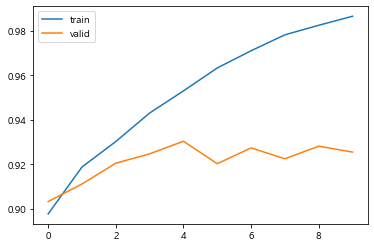

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()

show_history(history)

In [11]:
model.evaluate(test_images, test_oh_labels, batch_size=256, verbose=1)

40/40 [==============================] - 2s 53ms/step - loss: 0.3285 - accuracy: 0.9212


[0.3284514844417572, 0.9211999773979187]

### Dropout 적용하여 Fully Connected Layer의 오버피팅 조정
- Flatten을 하여 fully connect하게 되면 파라미터가 매우 늘어나면서 오버피팅 발생할 확률 증가
- 위의 실행결과를 보면 train에 대해서는 빠르게 1에 가까워졌는데 validation은 그에 비해 못미치는 성능으로 제자리 걸음하고있기 때문
- Dropout을 적용하면 특정 비율로 FC Layer 연결을 누락하여 계산 (model.summary에는 연결 끊어진것이 나오지는 않음)

In [12]:
from tensorflow.keras.layers import Dropout

input_tensor = Input(shape=(28,28,1))
x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor)
x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = Dropout(rate=0.5)(x)
x = Dense(100, activation='relu')(x)
output = Dense(10, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=output)
model.summary()
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dropout (Dropout)            (None, 10816)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               1081

In [13]:
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=10, validation_data=(val_images, val_oh_labels))

Epoch 1/10
399/399 [==============================] - 65s 162ms/step - loss: 0.6487 - accuracy: 0.7667 - val_loss: 0.3397 - val_accuracy: 0.8813
Epoch 2/10
399/399 [==============================] - 66s 167ms/step - loss: 0.3233 - accuracy: 0.8845 - val_loss: 0.2692 - val_accuracy: 0.9042
Epoch 3/10
399/399 [==============================] - 66s 165ms/step - loss: 0.2675 - accuracy: 0.9017 - val_loss: 0.2398 - val_accuracy: 0.9133
Epoch 4/10
399/399 [==============================] - 64s 160ms/step - loss: 0.2288 - accuracy: 0.9146 - val_loss: 0.2298 - val_accuracy: 0.9184
Epoch 5/10
399/399 [==============================] - 63s 157ms/step - loss: 0.2019 - accuracy: 0.9243 - val_loss: 0.2142 - val_accuracy: 0.9247
Epoch 6/10
399/399 [==============================] - 66s 165ms/step - loss: 0.1863 - accuracy: 0.9320 - val_loss: 0.2151 - val_accuracy: 0.9238
Epoch 7/10
399/399 [==============================] - 67s 167ms/step - loss: 0.1655 - accuracy: 0.9399 - val_loss: 0.2088 - val_ac

40/40 [==============================] - 2s 56ms/step - loss: 0.2272 - accuracy: 0.9261


[0.22724871337413788, 0.9261000156402588]

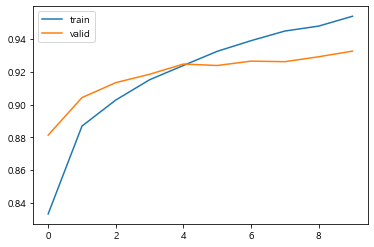

In [14]:
show_history(history)
model.evaluate(test_images, test_oh_labels, batch_size=256, verbose=1)